In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.distributions.normal import Normal
from torch.optim import SGD, Adagrad

mmdss 56.876650390625 225.24034962509256
mmds 0.14721923828125 2.913689472212343


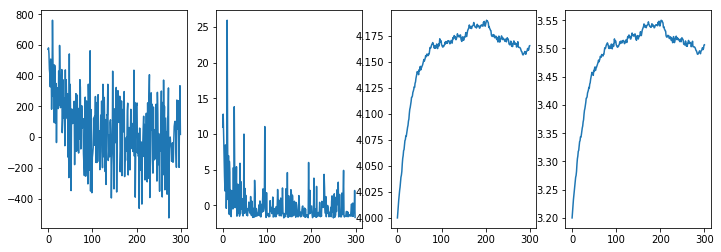

In [56]:
def ker_mean(x1, x2):
    return x1 * x2.T

def ker_squared_mean(x1, x2):
    return (x1**2 * x2.T**2)

def ker_var(x1, x2):
    mean1, mean2 = torch.mean(x1), torch.mean(x2)
    return (x1 - mean1)**2 * (x2.T - mean2)**2

def ker_exp(x1, x2):
    gramian = torch.exp(-(x1 - x2.T)**2 / 1e1)
    return gramian

def mmd(x1, x2, kernel):
    n1, n2 = x1.shape[0], x2.shape[0]
    idx1 = np.triu_indices(n1, k=1)
    idx1 = (torch.from_numpy(idx1[0]), torch.from_numpy(idx1[1]))
    idx2 = np.triu_indices(n2, k=1)
    idx2 = (torch.from_numpy(idx2[0]), torch.from_numpy(idx2[1]))
    
    gramian11 = kernel(x1, x1)
    gramian12 = kernel(x1, x2)
    gramian22 = kernel(x2, x2)
    mmd = torch.mean(gramian11[idx1]) + torch.mean(gramian22[idx2]) - 2 * torch.mean(gramian12)
#     mmd = torch.mean(gramian11) + torch.mean(gramian22) - 2 * torch.mean(gramian12)
    
    return mmd

def log_prob(x, mu, sd):
    return -0.5 * (x - mu)**2 / sd**2 - 0.5 * torch.log(torch.tensor([2 * math.pi * sd**2]))
    
def mmd_surr(xd, xm, kernel):
    
    logp = log_prob(xm, mu_m, sd_m)
    
    gramiandd = kernel(xd, xd)
    gramiandm = kernel(xd, xm)
    gramianmm = kernel(xm, xm)
    gramianmm.fill_diagonal_(0)
#     mmd_surr2 = torch.mean(((logp + logp.T) * gramianmm)[idx2]) - 2 * torch.mean(logp.T * gramiandm)
#     mmd_surr3 = torch.mean((logp * gramianmm)[idx2]) + torch.mean((logp.T * gramianmm)[idx2]) - 2 * torch.mean(logp.T * gramiandm)
    mmd_surr = 2 * torch.sum(logp * gramianmm) / (n_m * (n_m - 1)) - 2 * torch.mean(logp.T * gramiandm)
#     mmd_surr3 = 2 * torch.sum(logp * torch.sum(gramianmm, dim=1)[:, None]) / (n_m * (n_m - 1)) \
#               - 2 * torch.sum(logp * gramiandm.T) / (n_d * n_m)
#     mmd_surr3 = 2 * torch.mean((logp * gramianmm).T[idx2]) - 2 * torch.mean(logp.T * gramiandm)
#     print(mmd_surr, mmd_surr3)

    return mmd_surr

def mmd_surr_cv(xd, xm, kernel):
    
    logp = log_prob(xm, mu_m, sd_m)
    
    gramiandd = kernel(xd, xd)
    gramiandm = kernel(xd, xm)
    gramianmm = kernel(xm, xm)
    gramianmm.fill_diagonal_(0)
    
#     dlogdmu = (xm - mu_m.detach()) / sd_m.detach()**2
#     dlogdsd = (xm - mu_m.detach())**2 / sd_m.detach()**3 - 1 / sd_m.detach()
#     score = torch.cat([dlogdmu, dlogdsd], dim=1)
#     mean_score = torch.mean(score, dim=0)
#     var_score = torch.var(score, dim=0)
    mmd_weights = 2 * torch.sum(gramianmm, dim=1)[:, None] / (n_m * (n_m - 1)) - 2 * torch.sum(gramiandm.T, dim=1)[:, None] / (n_m * n_d)
#     corr_score2_weights = torch.mean(score * score * mmd_weights, dim=0)
#     cov_score2_weights = corr_score2_weights - mean_score * torch.mean(score * mmd_weights, dim=0)
#     a = cov_score2_weights / var_score
#     print(a.shape, score.shape)
#     print(logp.shape, a.shape)
    mmd_surr = torch.sum(logp * mmd_weights)# - torch.sum(a[None, :] * logp)
#     mmd_surr = 2 * torch.sum(logp * gramianmm) / (n_m * (n_m - 1)) - 2 * torch.mean(logp.T * gramiandm) - torch.sum(a[None, :] * logp)
#     print(mmd_surr.shape, sd_m[0].shape)
#     mmd_surr -= 1e-3 * torch.log(sd_m[0])
    
#     print(knwnkw)
    
    return mmd_surr

mu_d, sd_d = 5.0, 2.0
n_d = 1000
n_m = 1000

dist_data = Normal(loc=torch.tensor([mu_d]), scale=torch.tensor([sd_d]))
data = dist_data.sample(torch.tensor([n_d]))

mu_m, sd_m = torch.tensor([4.0], requires_grad=True), torch.tensor([3.2], requires_grad=True)
dist_m = Normal(loc=torch.tensor([mu_m]), scale=torch.tensor([sd_m]))
samples_m = dist_m.sample(torch.tensor([n_m]))

# logp = dist_m.log_prob(data_m)
logp = log_prob(samples_m, mu_m, sd_m)

n1, n2 = data.shape[0], samples_m.shape[0]
idx1 = np.triu_indices(n1, k=1)
idx1 = (torch.from_numpy(idx1[0]), torch.from_numpy(idx1[1]))
idx2 = np.triu_indices(n2, k=1)
idx2 = (torch.from_numpy(idx2[0]), torch.from_numpy(idx2[1]))

# ker, lr = ker_mean, 0
ker, lr = ker_squared_mean, 1e-4
# ker, lr = ker_var, 1e-3
# ker, lr = ker_exp, 1e0

optim = SGD([mu_m, sd_m], lr=lr)
# optim = Adagrad([mu_m, sd_m], lr=1e-1, lr_decay=0)
# optim = torch.optim.Adadelta([mu_m, sd_m], lr=1e-1, rho=0)

num_epochs = 300

mus, sds = [mu_m.detach().item()], [sd_m.detach().item()]
mmds, mmdss = [], []

for ii in range(num_epochs):
#     samples_m = dist_m.sample(torch.tensor([n_m]))
    samples_m = torch.normal(mu_m.detach().item(), sd_m.detach().item(), size=(n_m, 1))
    optim.zero_grad()
    
    _mmd_surr = mmd_surr(data, samples_m, ker)
#     _mmd_surr = mmd_surr_cv(data, samples_m, ker)
    
#     print(_mmd_surr)
    _mmd = mmd(data, samples_m, ker)
    _mmd_surr.backward()
    
#     print('before', mu_m.grad)
    
    if False:
        gramiandd = ker(data, data)
        gramiandm = ker(data, samples_m)
        gramianmm = ker(samples_m, samples_m)
        gramianmm.fill_diagonal_(0)
        dlogdmu = (samples_m - mu_m.detach()) / sd_m.detach()**2
        dlogdsd = (samples_m - mu_m.detach())**2 / sd_m.detach()**3 - 1 / sd_m.detach()
        score = torch.cat([dlogdmu, dlogdsd], dim=1)
        mean_score = torch.mean(score, dim=0)
        var_score = torch.var(score, dim=0)
#         mmd_weights = 2 * torch.sum(gramianmm, dim=1)[:, None] / (n_m * (n_m - 1)) - 2 * torch.sum(gramiandm.T, dim=1)[:, None] / (n_m * n_d)
        mmd_weights = 2 * torch.sum(gramianmm, dim=1)[:, None] / (n_m - 1) - 2 * torch.sum(gramiandm.T, dim=1)[:, None] / n_d
        corr_score2_weights = torch.mean(score * score * mmd_weights, dim=0)
        cov_score2_weights = corr_score2_weights - mean_score * torch.mean(score * mmd_weights, dim=0)
        a = cov_score2_weights / var_score
        mu_m.backward(torch.tensor([a[0] * mean_score[0]]))
        sd_m.backward(torch.tensor([a[1] * mean_score[1]]))
#     print('after', mu_m.grad)
    
    optim.step()
    mus.append(mu_m.detach().item())
    sds.append(sd_m.detach().item())
    mmds.append(_mmd.item())
    mmdss.append(_mmd_surr.item())
    
print('mmdss', np.mean(mmdss), np.std(mmdss))
print('mmds', np.mean(mmds), np.std(mmds))
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
ax1.plot(mmdss)
ax2.plot(mmds)
ax3.plot(mus)
ax4.plot(sds)

In [3]:
import time
time0 = time.time()

idx2 = np.triu_indices(samples_m.shape[0], k=1)
idx2 = (torch.from_numpy(idx2[0]), torch.from_numpy(idx2[1]))
gramianmm = ker(samples_m, samples_m)

print(time.time() - time0)

0.019603490829467773


In [6]:
torch.mean(((logp + logp.T) * gramianmm)[idx2]), torch.mean((logp * gramianmm + logp.T * gramianmm)[idx2])

(tensor(-121.4491, grad_fn=<MeanBackward0>),
 tensor(-121.4491, grad_fn=<MeanBackward0>))

In [7]:
import time
time0 = time.time()

gramianmm = ker(samples_m, samples_m)
gramianmm.fill_diagonal_(0)
print(2 * torch.sum(logp * gramianmm) / (n_m * (n_m - 1)))

print(time.time() - time0)

tensor(-121.4491, grad_fn=<DivBackward0>)
0.00495147705078125


tensor([-1.9683]) tensor([-2.5734]) None None


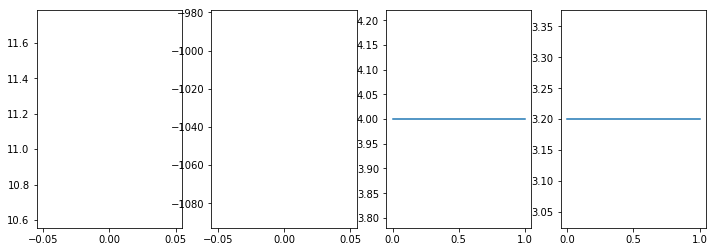

In [90]:
from torch.autograd import grad

ker = ker_mean

optim = Adagrad([mu_m, sd_m], lr=1e-1, lr_decay=0)

num_epochs = 1

mu_m, sd_m = torch.tensor([4.0], requires_grad=True), torch.tensor([3.2], requires_grad=True)

mus, sds = [mu_m.detach().item()], [sd_m.detach().item()]
mmds, mmdss = [], []

# print(sd_m.grad)

for ii in range(num_epochs):
    samples_m = torch.normal(mu_m.detach().item(), sd_m.detach().item(), size=(n_m, 1))
    optim.zero_grad()
#     _mmd_surr = mmd_surr(data, samples_m, ker)
#     _mmd = mmd(data, samples_m, ker)
#     _mmd_surr.backward()
#     optim.step()
#     _mmd_surr = mmd_surr(data, samples_m, ker)
#     print(mu_m.grad)
#     _mmd_surr.backward()
#     print(mu_m.grad)
#     optim.zero_grad()
#     print(mu_m.grad)

    # option 2
    logp = log_prob(samples_m, mu_m, sd_m)
    gramianmd = ker(samples_m, data)
    gramianmm = ker(samples_m, samples_m)
    gramianmm.fill_diagonal_(0)
    grad_outputs = 2 * torch.sum(gramianmm, dim=1)[:, None] / (n_m * (n_m - 1)) - 2 * torch.sum(gramianmd, dim=1)[:, None] / (n_m * n_d)
    g1, g2 = grad(outputs=logp, inputs=[mu_m, sd_m], grad_outputs=grad_outputs, retain_graph=True)
#     g1, g2 = grad(outputs=logp, inputs=[mu_m, sd_m], grad_outputs=grad_outputs, retain_graph=True)
#     _g1, _g2 = grad(outputs=logp, inputs=[mu_m, sd_m], grad_outputs=grad_outputs)
#     g1 = g1 + _g1
#     g2 = g2 + _g2
    print(g1, g2, mu_m.grad, sd_m.grad)
    
    # option 3
#     logp = log_prob(samples_m, mu_m, sd_m)
#     gramianmd = ker(samples_m, data)
#     gramianmm = ker(samples_m, samples_m)
#     gramianmm.fill_diagonal_(0)
#     grad_outputs1 = 2 * torch.sum(gramianmm, dim=1)[:, None] / (n_m * (n_m - 1))
# #     g1, g2 = grad(outputs=logp, inputs=[mu_m, sd_m], grad_outputs=grad_outputs, retain_graph=True)
#     grad_outputs2 = - 2 * torch.sum(gramianmd, dim=1)[:, None] / (n_m * n_d)
# #     _g1, _g2 = grad(outputs=logp, inputs=[mu_m, sd_m], grad_outputs=grad_outputs)
# #     g1 = g1 + _g1
# #     g2 = g2 + _g2
#     print(mu_m.grad)
#     logp.backward(grad_outputs1 + grad_outputs2, retain_graph=True)
    
#     print(mu_m.grad)
#     mus.append(mu_m.detach().item())
#     sds.append(sd_m.detach().item())
#     mmds.append(_mmd_surr.item())
#     mmdss.append(_mmd.item())
   
    optim.step()
    mus.append(mu_m.detach().item())
    sds.append(sd_m.detach().item())
    mmds.append(_mmd_surr.item())
    mmdss.append(_mmd.item())
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(12, 4), ncols=4)
ax1.plot(mmdss)
ax2.plot(mmds)
ax3.plot(mus)
ax4.plot(sds)

In [23]:
g1, g2 = grad(outputs=logp.T, inputs=[mu_m, sd_m], grad_outputs=grad_outputs.T, retain_graph=True)

In [33]:
# g1, g2 = grad(outputs=[logp[0, 0], logp[0, 0]], inputs=[mu_m, sd_m], retain_graph=True)
g1, g2 = grad(outputs=torch.unbind(logp), inputs=[mu_m, sd_m], retain_graph=True)

In [43]:
grad(outputs=torch.unbind(logp), inputs=[mu_m, sd_m], grad_outputs=[torch.tensor([1.])] * 1000, retain_graph=True)

(tensor([-11.5196]), tensor([317.0340]))

In [66]:
gramiandm = ker_mean(data, data_m)

In [40]:
logp.shape

torch.Size([1000, 1])

In [68]:
n1, n2 = xd.shape[0], xm.shape[0]
idx1 = np.triu_indices(n1, k=1)
idx1 = (torch.from_numpy(idx1[0]), torch.from_numpy(idx1[1]))
idx2 = np.triu_indices(n2, k=1)
idx2 = (torch.from_numpy(idx2[0]), torch.from_numpy(idx2[1]))

logp = log_prob(xm, mu_m, sd_m)

gramiandd = ker(xd, xd)
gramiandm = ker(xd, xm)
gramianmm = ker(xm, xm)
mmd_surr = ((logp + logp.T) * gramianmm)[idx2] - 2 * torch.mean(logp.T * gramiandm)

torch.Size([200, 1])

In [ ]:
_mmd_surr